In [1]:
import  numpy as np 
import sunpy 
import glob
import os
from sunpy.map import Map
import astropy.units as u
from sunpy.net import Fido, attrs as a
from astropy.coordinates import SkyCoord
from datetime import  date, datetime
from astropy.time import Time


In [2]:
t_0, t_f    = '2018-01-01T00:00:00.00', '2018-01-30T00:00:00.00'
date_format = "%Y-%m-%dT%H:%M:%S.%f"

Tx, Ty      = 0, 0  # arcsec
aiasq       =  1210 #arcsec
start_time  = datetime.strptime(t_0, date_format)
ends_time   = datetime.strptime(t_f, date_format)


top_right   = SkyCoord((Tx+aiasq)*u.arcsec, (Ty+aiasq)*u.arcsec, obstime=start_time, observer="earth", frame="helioprojective")
bottom_left = SkyCoord((Tx-aiasq)*u.arcsec, (Ty-aiasq)*u.arcsec, obstime=start_time, observer="earth", frame="helioprojective")
item = 171
sample_data = 725*u.hour
email= "email.gmail.com"

In [3]:
def get_query_sdo(item, bottom_left, top_right, start_time, ends_time, email, sample_data ,tracking=False):
    """
    Constructs a query to search for Solar Dynamics Observatory (SDO) data based on specified parameters.

    Parameters:
        item (int or str): The data item to search for (e.g., wavelength in Angstrom, 'hmi', 'dopplergram').
        bottom_left (tuple): Coordinates for the bottom left corner of the search area.
        top_right (tuple): Coordinates for the top right corner of the search area.
        start_time (str): Start time of the data search period.
        end_time (str): End time of the data search period.
        email (str): Email address for notification.
        sample_data (astropy.units.Quantity): Sampling interval for the data.
        tracking (bool): Whether to enable tracking (default is False).

    Returns:
        Query object for Fido search, or raises a ValueError for invalid inputs.
    """
    # Define the cadence lists for AIA
    aia_cad_12 = [94, 131, 171, 193, 211, 304, 335]
    aia_cad_24 = [1600, 1700]

    if item not in [94, 131, 171, 193, 211, 304, 335, 1600, 1700,  'hmi', 'aia', 'HMI', 'AIA', 'dopplergram', 'DOPPLERGRAM', 'Dopplergram']:
        raise ValueError("Supported methods are 'pearson' and 'ssim' only")
    
    if (f"{item}".lower() in ['hmi', 'dopplergram']) * (sample_data <45*u.second): 
        raise ValueError("The selected Sample is lower than the Instrumen Cadence")
    
    if (item in aia_cad_12) * (sample_data <12*u.second): 
        raise ValueError("The selected Sample is lower than the Instrumen Cadence")
    
    if (item in aia_cad_24) * (sample_data <24*u.second): 
        raise ValueError("The selected Sample is lower than the Instrumen Cadence")
            

    # Check if the item is in the aia_cad_12 list
    if item in aia_cad_12:
        cutout = a.jsoc.Cutout(bottom_left, top_right=top_right, tracking=tracking)
        query = Fido.search(
            a.Time(start_time, ends_time),
            a.Wavelength(item*u.angstrom),
            a.Sample(sample_data),
            a.jsoc.Series.aia_lev1_euv_12s,
            a.jsoc.Notify(email),
            a.jsoc.Segment.image,
            cutout)
    
    # Check if the item is in the aia_cad_12 list
    elif item in aia_cad_24:
        cutout = a.jsoc.Cutout(bottom_left, top_right=top_right, tracking=tracking)
        query = Fido.search(
            a.Time(start_time, ends_time),
            a.Wavelength(item*u.angstrom),
            a.Sample(sample_data),
            a.jsoc.Series('aia.lev1_uv_24s'),            
            a.jsoc.Notify(email),
            a.jsoc.Segment.image,
            cutout)
    
    # Check if the item matches 'hmi' (case insensitive)
    elif item.lower() == 'hmi':
        cutout = a.jsoc.Cutout(bottom_left, top_right=top_right, tracking=True)
        cadence = 45
        print('magnetogram, cadence:',cadence)
        query = Fido.search(
            a.Time(start_time, ends_time),
            a.Sample(sample_data),
            a.jsoc.Series('hmi.M_45s'),
            a.jsoc.Notify(email),
            a.jsoc.Segment.magnetogram,
            cutout)
        
    elif item.lower() == 'dopplergram':
        cutout = a.jsoc.Cutout(bottom_left, top_right=top_right, tracking=True)
        cadence = 45
        print('dopplergram, cadence:',cadence)
        query = Fido.search(
            a.Time(start_time, ends_time),
            a.Sample(sample_data),
            a.jsoc.Series('hmi.v_45s'),
            a.jsoc.Notify(email),
            a.jsoc.Segment.dopplergram,
            cutout)
    else:
        # Handle the case where the item is not in any list
        query = None
        print('Please check the provided information')
    
    return query


In [4]:
query_result = get_query_sdo(item, bottom_left, top_right, start_time, ends_time, email, sample_data ,tracking=False)

In [5]:
query_result

T_REC,TELESCOP,INSTRUME,WAVELNTH,CAR_ROT
str20,str7,str5,int64,int64
2017-12-31T23:59:59Z,SDO/AIA,AIA_3,171,2199


In [6]:
file_download = Fido.fetch(query_result, path='test_data/')

Export request pending. [id=JSOC_20240604_000439, status=2]
Waiting for 0 seconds...
1 URLs found for download. Full request totalling 11MB


Files Downloaded:   0%|          | 0/1 [00:00<?, ?file/s]

aia.lev1_euv_12s.2017-12-31T235959Z.171.image.fits:   0%|          | 0.00/11.4M [00:00<?, ?B/s]

Observatory,SDO
Instrument,AIA 3
Detector,AIA
Measurement,171.0 Angstrom
Wavelength,171.0 Angstrom
Observation Date,2018-01-01 00:00:09
Exposure Time,2.000161 s
Dimension,[4037. 4037.] pix
Coordinate System,helioprojective
Scale,[0.59948897 0.59948897] arcsec / pix
Reference Pixel,[2018.48999 2018.43005] pix

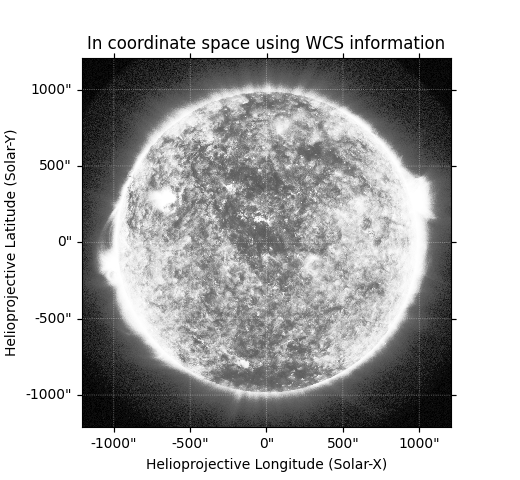
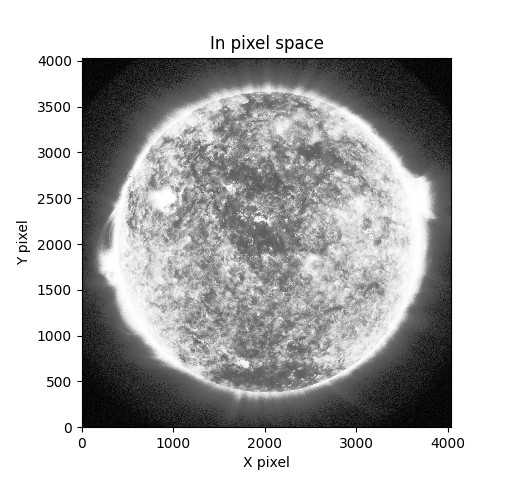
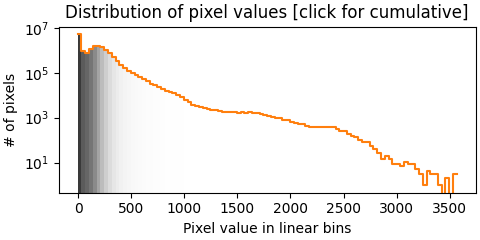
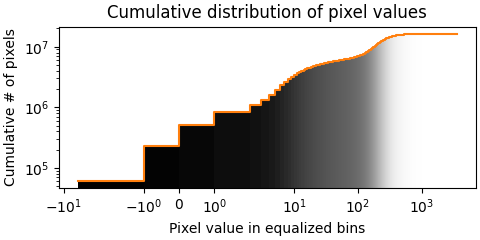

In [7]:
sunpy.map.Map("test_data/aia.lev1_euv_12s.2017-12-31T235959Z.171.image.fits")

In [13]:
query

T_REC,TELESCOP,INSTRUME,WAVELNTH,CAR_ROT
str20,str7,str5,int64,int64
2017-12-31T23:59:59Z,SDO/AIA,AIA_3,171,2199


In [14]:
file_download = Fido.fetch(query, path='test_data/')

Export request pending. [id=JSOC_20240604_000439, status=2]
Waiting for 0 seconds...
Export request pending. [id=JSOC_20240604_000439, status=1]
Waiting for 5 seconds...
Export request pending. [id=JSOC_20240604_000439, status=1]
Waiting for 5 seconds...
Export request pending. [id=JSOC_20240604_000439, status=1]
Waiting for 5 seconds...
1 URLs found for download. Full request totalling 11MB


Files Downloaded:   0%|          | 0/1 [00:00<?, ?file/s]

aia.lev1_euv_12s.2017-12-31T235959Z.171.image.fits:   0%|          | 0.00/11.4M [00:00<?, ?B/s]

Observatory,SDO
Instrument,AIA 3
Detector,AIA
Measurement,171.0 Angstrom
Wavelength,171.0 Angstrom
Observation Date,2018-01-01 00:00:09
Exposure Time,2.000161 s
Dimension,[4037. 4037.] pix
Coordinate System,helioprojective
Scale,[0.59948897 0.59948897] arcsec / pix
Reference Pixel,[2018.48999 2018.43005] pix

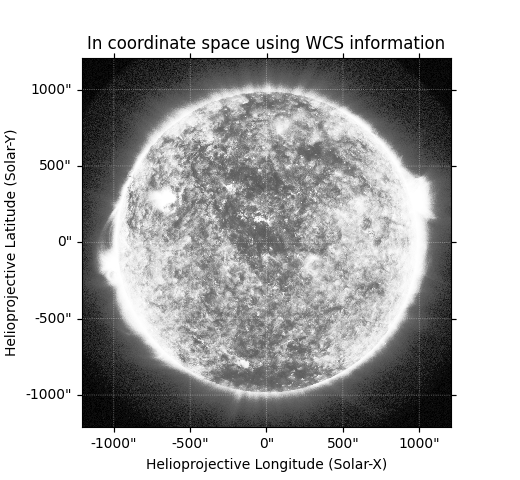
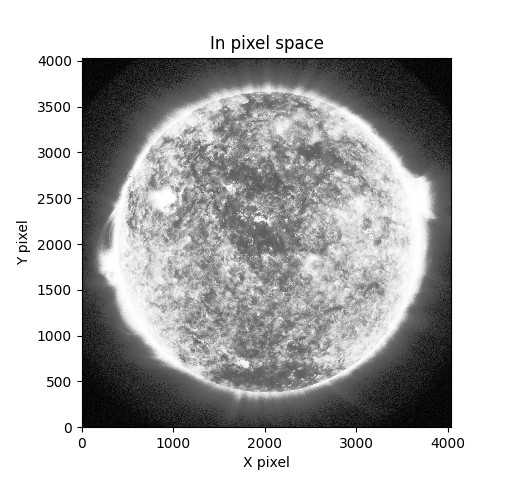
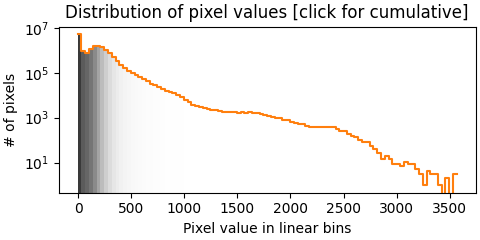
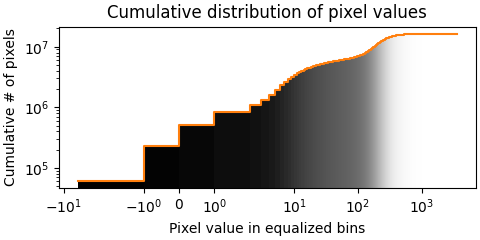

In [15]:
sunpy.map.Map("test_data/aia.lev1_euv_12s.2017-12-31T235959Z.171.image.fits")

In [ ]:
query_data= get_query('dopplergram', bottom_left, top_right, start_time, ends_time, 'fjordoneza@unal.edu.co')
print(query_data)

In [11]:
import matplotlib.pyplot as plt
from scipy import ndimage

import sunpy.map
from sunpy.data.sample import AIA_171_IMAGE

###############################################################################
# We start with the sample data.

aiamap_mask = sunpy.map.Map(AIA_193_IMAGE)
aiamap = sunpy.map.Map(AIA_193_IMAGE)

Observatory,SDO
Instrument,AIA 2
Detector,AIA
Measurement,193.0 Angstrom
Wavelength,193.0 Angstrom
Observation Date,2011-06-07 06:33:07
Exposure Time,1.999683 s
Dimension,[1024. 1024.] pix
Coordinate System,helioprojective
Scale,[2.403032 2.403032] arcsec / pix
Reference Pixel,[511.5 511.5] pix

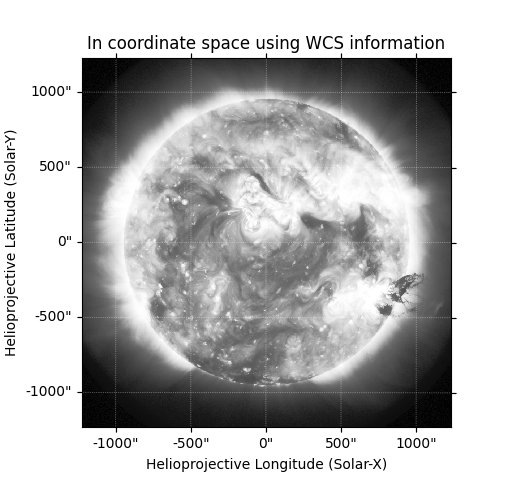
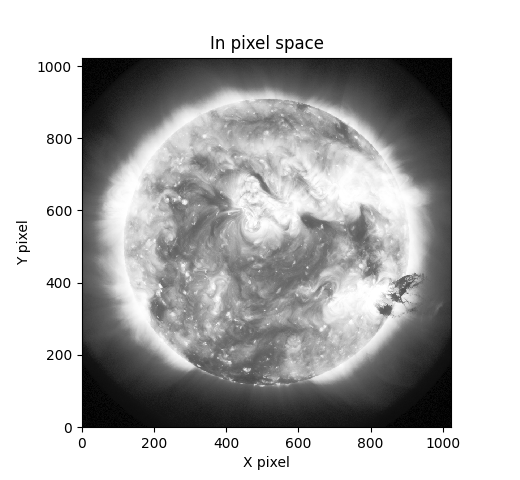
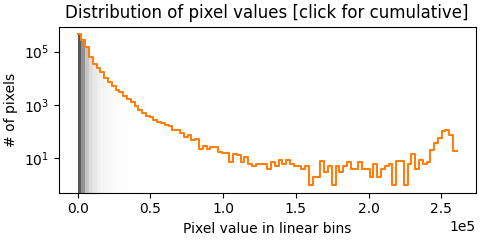
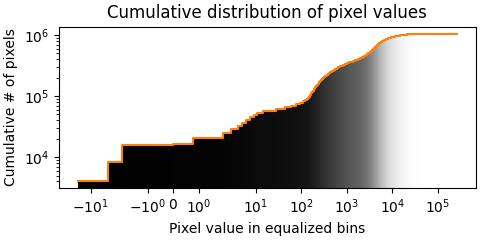

In [12]:
aiamap

In [34]:
wl = [94, 131, 171, 193, 211, 304, 335, 1600, 1700]

In [29]:
result= Fido.search(a.Time('2012-01-01T00:00', '2012-12-01T00:00'), a.Instrument.aia, a.Wavelength(171*u.angstrom), a.Sample(725*u.hour))  

In [30]:
result

Start Time,End Time,Source,Instrument,Wavelength,Provider,Physobs,Wavetype,Extent Width,Extent Length,Extent Type,Size
,,,,Angstrom,,,,,,,Mibyte
Time,Time,str3,str3,float64[2],str4,str9,str6,str4,str4,str8,float64
2012-01-01 00:00:00.000,2012-01-01 00:00:01.000,SDO,AIA,171.0 .. 171.0,JSOC,intensity,NARROW,4096,4096,FULLDISK,64.64844
2012-01-31 05:00:00.000,2012-01-31 05:00:01.000,SDO,AIA,171.0 .. 171.0,JSOC,intensity,NARROW,4096,4096,FULLDISK,64.64844
2012-03-01 10:00:00.000,2012-03-01 10:00:01.000,SDO,AIA,171.0 .. 171.0,JSOC,intensity,NARROW,4096,4096,FULLDISK,64.64844
2012-03-31 15:00:00.000,2012-03-31 15:00:01.000,SDO,AIA,171.0 .. 171.0,JSOC,intensity,NARROW,4096,4096,FULLDISK,64.64844
2012-04-30 20:00:00.000,2012-04-30 20:00:01.000,SDO,AIA,171.0 .. 171.0,JSOC,intensity,NARROW,4096,4096,FULLDISK,64.64844
2012-05-31 01:00:00.000,2012-05-31 01:00:01.000,SDO,AIA,171.0 .. 171.0,JSOC,intensity,NARROW,4096,4096,FULLDISK,64.64844
2012-06-30 06:00:00.000,2012-06-30 06:00:01.000,SDO,AIA,171.0 .. 171.0,JSOC,intensity,NARROW,4096,4096,FULLDISK,64.64844
2012-07-30 11:00:11.000,2012-07-30 11:00:12.000,SDO,AIA,171.0 .. 171.0,JSOC,intensity,NARROW,4096,4096,FULLDISK,64.64844


In [31]:
downloaded_files = Fido.fetch(result, path='data_downloaded/')  

Files Downloaded:   0%|          | 0/12 [00:00<?, ?file/s]

aia_lev1_171a_2012_01_01t00_00_00_34z_image_lev1.fits:   0%|          | 0.00/12.6M [00:00<?, ?B/s]

aia_lev1_171a_2012_04_30t20_00_00_34z_image_lev1.fits:   0%|          | 0.00/12.3M [00:00<?, ?B/s]

aia_lev1_171a_2012_01_31t05_00_00_34z_image_lev1.fits:   0%|          | 0.00/12.4M [00:00<?, ?B/s]

aia_lev1_171a_2012_03_01t10_00_00_34z_image_lev1.fits:   0%|          | 0.00/12.3M [00:00<?, ?B/s]

aia_lev1_171a_2012_03_31t15_00_00_35z_image_lev1.fits:   0%|          | 0.00/12.4M [00:00<?, ?B/s]

aia_lev1_171a_2012_05_31t01_00_00_35z_image_lev1.fits:   0%|          | 0.00/12.4M [00:00<?, ?B/s]

aia_lev1_171a_2012_06_30t06_00_00_34z_image_lev1.fits:   0%|          | 0.00/12.1M [00:00<?, ?B/s]

aia_lev1_171a_2012_07_30t11_00_11_35z_image_lev1.fits:   0%|          | 0.00/12.3M [00:00<?, ?B/s]

aia_lev1_171a_2012_08_29t16_00_11_34z_image_lev1.fits:   0%|          | 0.00/12.4M [00:00<?, ?B/s]

aia_lev1_171a_2012_09_28t21_00_08_50z_image_lev1.fits:   0%|          | 0.00/6.93M [00:00<?, ?B/s]

aia_lev1_171a_2012_10_29t02_00_11_34z_image_lev1.fits:   0%|          | 0.00/12.3M [00:00<?, ?B/s]

aia_lev1_171a_2012_11_28t07_00_11_34z_image_lev1.fits:   0%|          | 0.00/12.3M [00:00<?, ?B/s]

In [39]:

wl = [171]
os.system('mkdir SDO')
for i in range(len(wl)):
    os.system('mkdir SDO/{}'.format(wl[i]))
    result= Fido.search(a.Time('2012-01-01T00:00', '2012-2-01T00:00'), a.Instrument.aia, a.Wavelength(wl[i]*u.angstrom), a.Sample(725*u.hour))
    downloaded_files = Fido.fetch(result, path='SDO/{}')  

mkdir: cannot create directory ‘SDO’: File exists
mkdir: cannot create directory ‘SDO/171’: File exists


Files Downloaded:   0%|          | 0/2 [00:00<?, ?file/s]

2/0 files failed to download. Please check `.errors` for details


In [32]:
all_aia_data = glob.glob("data_downloaded/*.fits")